In [2]:
# -----------Distinguishing birds from airplanes-----------
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [6]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [8]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [10]:
# the dataset is small, and we only need indexing and len to work on our dataset. It doesn’t actually have to be a subclass of torch.utils.data.dataset.Dataset!
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]
# The cifar2 object satisfies the basic requirements for a Dataset—that is, __len__ and __getitem__ are defined

In [12]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1>
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [14]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [16]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [18]:
softmax(x).sum()

tensor(1.)

In [20]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [22]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])
False
True


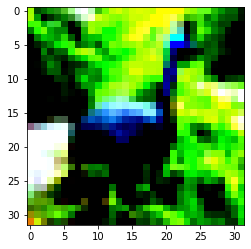

In [26]:
img, _ = cifar2[0]
print(img.shape)
print(img.permute(1, 2, 0).shape)
print(img.requires_grad)

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [14]:
img_batch = img.view(-1).unsqueeze(0)
print(img_batch.shape)

torch.Size([1, 3072])


In [15]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [16]:
_, index = torch.max(out, dim=1)

index

tensor([1])

In [17]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)
print(out[[0, 1, 2, 3], [0, 0, 1, 1]])
print(out[:, [0, 0, 1, 1]])

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([0.6000, 0.9000, 0.7000, 0.8000])
tensor([[0.6000, 0.6000, 0.4000, 0.4000],
        [0.9000, 0.9000, 0.1000, 0.1000],
        [0.3000, 0.3000, 0.7000, 0.7000],
        [0.2000, 0.2000, 0.8000, 0.8000]])


tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [18]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [19]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [20]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

print(0.6 * 0.9 * 0.7 * 0.8)
likelihood(out)

0.3024


tensor([0.3024])

In [21]:
# -----------negative log likelihood(NLL):
# It has the expression NLL = - sum(log(out_i[c_i]))
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [22]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [23]:
# -----------MSE loss:
# 在图7.11中，我们可以看到，当预测偏离目标时，交叉熵损失有一定的斜率（在低损耗角，为正确的分类分配了99.97％的预测概率），而在MSE，开始时就忽略了非常错误的预测，饱和会更早地发生，而且至关重要的是也是如此。 根本原因是，MSE的斜率太低，无法补偿针对错误预测的softmax函数的平坦度。 这就是为什么概率的MSE不适用于分类工作的原因。
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [24]:
# NLL loss
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [25]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [26]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [27]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [28]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [29]:
log_softmax(x)

tensor([[-104.,    0.]])

In [30]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [31]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [32]:
# -----------nn.NLLLoss：
# it does not take probabilities but rather takes a tensor of log probabilities as input.
# 它的输入约定背后有一个很好的理由：当概率接近零时，获取概率的对数是很棘手的。 解决方法是使用nn.LogSoftmax而不是nn.Softmax，这要使计算数值稳定。

# -----------交叉熵计算：
# logSoftmax(x) =
#          [[x1_logsm_label1, x1_logsm_label2, ...],
#                       ...,
#           [xn_logsm_label1, xn_logsm_label2, ...]]
# 
# target = [x1_true_label,
#               ...,
#           xn_true_label]
# 
# out = nn.LogSoftmax(dim=1)(x)
# out = nn.NLLLoss()(out, target)
loss = nn.NLLLoss()

In [33]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))
print(out, label)
print(len(cifar2))

loss(out, torch.tensor([label]))

tensor([[-0.9211, -0.5077]], grad_fn=<LogSoftmaxBackward>) 1
10000


tensor(0.5077, grad_fn=<NllLossBackward>)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

model.cuda(4)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss().cuda(4)

n_epochs = 100

# -----------updating the model at each sample:
# in this case we apply changes to parameters based on a very partial estimation of the gradient on a single sample.
# However, what is a good direction for reducing the loss based on one sample might not be a good direction for others.
for epoch in range(n_epochs):
    for img, label in cifar2:
        img, label = img.cuda(4), torch.tensor([label]).cuda(4)
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, label)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 8.504663
Epoch: 1, Loss: 4.863072
Epoch: 2, Loss: 5.107162
Epoch: 3, Loss: 9.041813
Epoch: 4, Loss: 5.057918
Epoch: 5, Loss: 10.196898
Epoch: 6, Loss: 3.899864
Epoch: 7, Loss: 6.083263
Epoch: 8, Loss: 6.799435
Epoch: 9, Loss: 11.753166
Epoch: 10, Loss: 10.532894
Epoch: 11, Loss: 2.975142
Epoch: 12, Loss: 6.763713
Epoch: 13, Loss: 4.038625
Epoch: 14, Loss: 6.043227
Epoch: 15, Loss: 0.972028
Epoch: 16, Loss: 4.059655
Epoch: 17, Loss: 3.632610
Epoch: 18, Loss: 11.354353
Epoch: 19, Loss: 8.461744
Epoch: 20, Loss: 5.849610
Epoch: 21, Loss: 0.040118
Epoch: 22, Loss: 0.007063
Epoch: 23, Loss: 8.363232
Epoch: 24, Loss: 7.303123
Epoch: 25, Loss: 0.876009
Epoch: 26, Loss: 10.616013
Epoch: 27, Loss: 1.394941
Epoch: 28, Loss: 13.046523
Epoch: 29, Loss: 9.538383
Epoch: 30, Loss: 9.064582


KeyboardInterrupt: 

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# imgs is a tensor of size 64 × 3 × 32 × 32
# -----------SGD(stochastic gradient descent):
# SGD代表随机梯度下降，处理少量的小批量的shuffled数据。事实证明，在微型批处理上估计的梯度比在整个数据集上估计的梯度较差，但它有助于收敛并防止优化过程陷入其在过程中遇到的局部最小值。
# 如图7.13所示，小批处理产生的梯度随机偏离理想轨迹，这就是我们要使用合理的小学习率的部分原因。
# 在每个时期对数据集进行shuffle(即随机抽样)有助于确保在小批量上估计的梯度代表整个数据集上计算出的梯度。
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1)).cuda(4)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss().cuda(4)

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs, labels = Variable(imgs.cuda(4)), Variable(labels.cuda(4))
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.460739
Epoch: 5, Loss: 0.479630
Epoch: 10, Loss: 0.374415
Epoch: 15, Loss: 0.160992
Epoch: 20, Loss: 0.266349
Epoch: 25, Loss: 0.402808
Epoch: 30, Loss: 0.291886
Epoch: 35, Loss: 0.151352
Epoch: 40, Loss: 0.069002
Epoch: 45, Loss: 0.115923
Epoch: 50, Loss: 0.232727
Epoch: 55, Loss: 0.077621
Epoch: 60, Loss: 0.033185
Epoch: 65, Loss: 0.090142
Epoch: 70, Loss: 0.045739
Epoch: 75, Loss: 0.014939
Epoch: 80, Loss: 0.041031
Epoch: 85, Loss: 0.011622
Epoch: 90, Loss: 0.013821
Epoch: 95, Loss: 0.011822


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.732168
Epoch: 1, Loss: 0.348352
Epoch: 2, Loss: 0.318960
Epoch: 3, Loss: 0.313264
Epoch: 4, Loss: 0.378358
Epoch: 5, Loss: 0.276529
Epoch: 6, Loss: 0.443889
Epoch: 7, Loss: 0.436946
Epoch: 8, Loss: 0.324288
Epoch: 9, Loss: 0.274647
Epoch: 10, Loss: 0.291681
Epoch: 11, Loss: 0.242894
Epoch: 12, Loss: 0.301849
Epoch: 13, Loss: 0.202063
Epoch: 14, Loss: 0.389276
Epoch: 15, Loss: 0.167129
Epoch: 16, Loss: 0.135282
Epoch: 17, Loss: 0.385485
Epoch: 18, Loss: 0.453852
Epoch: 19, Loss: 0.641304
Epoch: 20, Loss: 0.287667
Epoch: 21, Loss: 0.337029
Epoch: 22, Loss: 0.393282
Epoch: 23, Loss: 0.409480
Epoch: 24, Loss: 0.138473
Epoch: 25, Loss: 0.690729
Epoch: 26, Loss: 0.572156
Epoch: 27, Loss: 0.078534
Epoch: 28, Loss: 0.324833
Epoch: 29, Loss: 0.262829
Epoch: 30, Loss: 0.430449
Epoch: 31, Loss: 0.071872
Epoch: 32, Loss: 0.058039
Epoch: 33, Loss: 0.052903
Epoch: 34, Loss: 0.065879
Epoch: 35, Loss: 0.107696
Epoch: 36, Loss: 0.305224
Epoch: 37, Loss: 0.098637
Epoch: 38, Loss: 0.139

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.997700


In [38]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.821000


In [39]:
# 在这里，我们尝试在输出端更平缓地逐渐减少特征数量，希望中间层能够在越来越短的中间输出中更好地压缩信息。
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [40]:
# The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss. 
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.641261
Epoch: 1, Loss: 0.525149
Epoch: 2, Loss: 0.466143
Epoch: 3, Loss: 0.451913
Epoch: 4, Loss: 0.343860
Epoch: 5, Loss: 0.309738
Epoch: 6, Loss: 0.485261
Epoch: 7, Loss: 0.283789
Epoch: 8, Loss: 0.301561
Epoch: 9, Loss: 0.408200
Epoch: 10, Loss: 0.346715
Epoch: 11, Loss: 0.358134
Epoch: 12, Loss: 0.388485
Epoch: 13, Loss: 0.378096
Epoch: 14, Loss: 0.518019
Epoch: 15, Loss: 0.359279
Epoch: 16, Loss: 0.420371
Epoch: 17, Loss: 0.366249
Epoch: 18, Loss: 0.282639
Epoch: 19, Loss: 0.468854
Epoch: 20, Loss: 0.467920
Epoch: 21, Loss: 0.237441
Epoch: 22, Loss: 0.243472
Epoch: 23, Loss: 0.566929
Epoch: 24, Loss: 0.316143
Epoch: 25, Loss: 0.336322
Epoch: 26, Loss: 0.473064
Epoch: 27, Loss: 0.407040
Epoch: 28, Loss: 0.252989
Epoch: 29, Loss: 0.195740
Epoch: 30, Loss: 0.663084
Epoch: 31, Loss: 0.659899
Epoch: 32, Loss: 0.285113
Epoch: 33, Loss: 0.212042
Epoch: 34, Loss: 0.324017
Epoch: 35, Loss: 0.097063
Epoch: 36, Loss: 0.181754
Epoch: 37, Loss: 0.091362
Epoch: 38, Loss: 0.069

In [42]:
# 在验证集上对已训练的model进行验证：过拟合
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999700


In [43]:
# 在验证集上对已训练的model进行验证：过拟合
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.801000


In [44]:
# numel()：返回数组中元素的个数
sum([p.numel() for p in model.parameters()])

3737474

In [45]:
#  We might want to differentiate the number of trainable parameters from the overall model size. 
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [46]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [47]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [48]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [52]:
linear = nn.Linear(3072, 1024)
print(1024 * (3072 + 1))
linear.weight.shape, linear.bias.shape

3146752


(torch.Size([1024, 3072]), torch.Size([1024]))

In [54]:
# -----------The limits of going fully connected:
# 1. a fully connected network is not translation invariant. 
# 2. We would then have to augment the dataset—that is, apply random translations(torchvision.transforms) to images during training—so the network would have a chance to see Spitfires all over the image, and we would need to do this for every image in the dataset.
# 3. However, this data augmentation strategy comes at a cost: the number of hidden features—that is, of parameters—must be large enough to store the information about all of these translated replicas.
# 4. it was better at memorizing the training set than it was at generalizing properties of birds and airplanes: we have both too many parameters (making it easier for the model to memorize the training set) but no position independence (making it harder to generalize)
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
# -----------Summarizing, by switching to convolutions, we get:
# 1. Local operations on neighborhoods
# 2. Translation invariance
# 3. Models with a lot fewer parameters

In [55]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [56]:
conv.bias.shape

torch.Size([16])

In [57]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [58]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


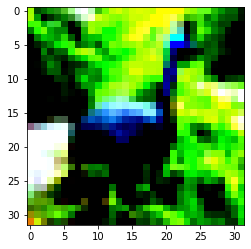

In [59]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

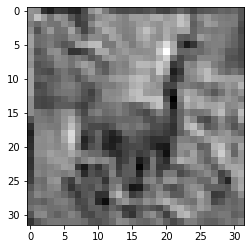

torch.Tensor

In [60]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
type(output[0, 0].detach())

In [57]:
output.shape

torch.Size([1, 16, 30, 30])

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [14]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [15]:
# Disabling gradient calculation is useful for inference, when you are sure that you will not call method:Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
# why it will reduce memory consumption?
# In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.
with torch.no_grad():
    conv.bias.zero_()

In [16]:
with torch.no_grad():
    # set weights to a constant value so that each pixel in the output gets 
    # the mean of its neighbors. 
    conv.weight.fill_(1.0 / 9.0)

tensor([[ 0.1996, -0.0273,  ..., -0.5446, -0.4305],
        [ 0.3406,  0.1158,  ..., -0.9808, -0.8079],
        ...,
        [ 0.5163,  0.6754,  ..., -1.1325, -0.5512],
        [ 0.4821,  0.6350,  ..., -0.7778, -0.3840]])


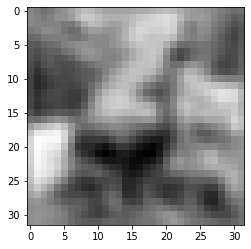

In [19]:
# the filter produces a blurred version of the image
# 输出的每个像素点都是原图像中相邻9个像素的平均值
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
print(output[0, 0].detach())
plt.show()

In [63]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1).cuda(4)
print(conv.weight.shape)

# 如果不用torch.no_grad()包裹，会得到grad_fn=<CopySlices>的跟踪
with torch.no_grad():
    # an edge-detection kernel: the kernel highlights the vertical edge 
    # between two horizontally adjacent regions.
    conv.weight[:, :] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()
    print(conv.bias)
    print(conv.weight[0, 0])

    print(conv.weight[0, 0].detach())

    output = conv(img.unsqueeze(0))
    print(output.requires_grad == True)


torch.Size([1, 3, 3, 3])
tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]], device='cuda:4', requires_grad=True)


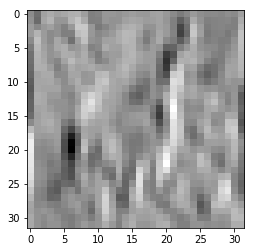

In [64]:
# 边缘加深
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [28]:
pool = nn.MaxPool2d(2)

In [29]:
print(img.shape)

output = pool(img.unsqueeze(0))

output.shape

torch.Size([3, 32, 32])


torch.Size([1, 3, 16, 16])

In [31]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2))

In [36]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            
            nn.Flatten(), # WARNING: something missing here
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [37]:
sum([p.numel() for p in model.parameters()])

18090

In [38]:
model(img.unsqueeze(0))

tensor([[-0.0164, -0.0193]], grad_fn=<AddmmBackward>)

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        # out = out.view(x.shape[0]， -1)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = Net()
for name, param in model.named_parameters():
    print(name)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [54]:
model = Net()

print(sum([p.numel() for p in model.parameters()]))
print(sum([p.numel() for p in model.fc1.parameters()]))
print(sum([p.numel() for p in model.fc2.parameters()]))

print("fc params' numel: ", sum([p.numel() for name, p in model.named_parameters() if 'fc' in name]))
print("conv params' numel: ", sum([p.numel() for name, p in model.named_parameters() if 'fc' not in name]))

18090
16416
66
fc params' numel:  16482
conv params' numel:  1608


In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
model = Net()
sum([p.numel() for p in model.parameters()])
# model(img.unsqueeze(0))

18090

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

# os.environ["CUDA_VISIBLE_DEVICES"] = "4"

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net().cuda(4)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss().cuda(4)

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs, labels = Variable(imgs.cuda(4)), Variable(labels.cuda(4))
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch == 0 or epoch % 10 == 0:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.678978
Epoch: 10, Loss: 0.231676
Epoch: 20, Loss: 0.514590
Epoch: 30, Loss: 0.109054
Epoch: 40, Loss: 0.180477
Epoch: 50, Loss: 0.376109
Epoch: 60, Loss: 0.112484
Epoch: 70, Loss: 0.027833
Epoch: 80, Loss: 0.109177
Epoch: 90, Loss: 0.175938


In [17]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = Variable(imgs.cuda(4)), Variable(labels.cuda(4))
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.883900


In [19]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = Variable(imgs.cuda(4)), Variable(labels.cuda(4))
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.855500


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
sum([p.numel() for p in model.parameters()])

18090

In [19]:

model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))

tensor([[ 0.1292, -0.1504]], grad_fn=<AddmmBackward>)